In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import pandas as pd
import imageio

from PIL import Image

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from matplotlib import pyplot as plt

# Create the model

In [2]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, box_batch_size_per_image=3000, box_detections_per_img=2500)

In [3]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
model_path = './fasterrcnn.pth'

model.load_state_dict(torch.load(model_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Evaluate

In [5]:
def evaluate(img, show_img=False):
    image = torch.as_tensor(img / 255, dtype=torch.float)
    image = image.permute(2, 0, 1)
    centroids = []
    
    model.eval()
    cpu_device = torch.device("cpu")

    outputs = model([image])
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

    boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32)
    
    

    for box in boxes:
    #     print(box)
        cX, cY = (box[2] + box[0]) // 2, (box[3] + box[1]) // 2
        centroids.append((cX, cY))
        
        img = cv2.rectangle(img,
                              (cX, cY),
                              (cX+5, cY+5),
                              (220, 0, 0), 5)
        
        
    
    if show_img:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        ax.set_axis_off()
        ax.imshow(img)
    
    return img, centroids

## Write to csv

C:\Users\manos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


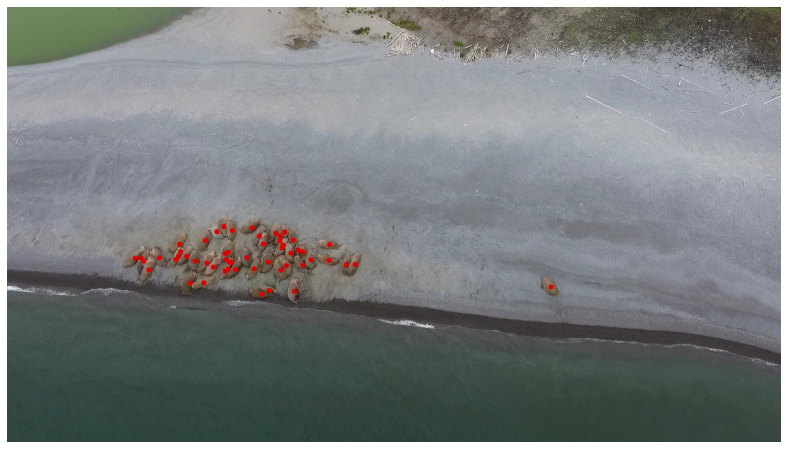

In [6]:
for img_path in os.listdir('./test/images/'):
    image = imageio.imread(f'./test/images/{img_path}', )
    img, centroids = evaluate(image, show_img=True)

    df = pd.DataFrame(centroids, columns=['x', 'y'])
    df.to_csv(f'./test/csv/{img_path}.csv', index=False)
    
    break